# TIF345/FYM345: Project 3: A Galton board on a rocking ship

# Names 
Jonatan Haraldsson [jonhara@chalmers.se](mailto:jonhara@chalmers.se)

Jesper Noord [noord@chalmers.se](mailto:noord@chalmers.se)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import sklearn
import pandas as pd
import emcee
import numpy as np
import random
import tqdm
import keras as keras
import tensorflow as tf

# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 16
plt.rcParams['font.size'] = font_size
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

sns.set_palette('deep')
from matplotlib import cbook, cm
from seaborn import cm
from matplotlib.colors import LightSource
# plot in separate window
%matplotlib inline

rng = np.random.default_rng(seed = 42)

### Importing and massaging data

In [25]:
board_data = np.load('board_data.npy')

board_df = pd.DataFrame(board_data, columns = [f'bin_{i}' for i in range(32)])

display(board_df)


,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,bin_6,bin_7,bin_8,bin_9,...,bin_22,bin_23,bin_24,bin_25,bin_26,bin_27,bin_28,bin_29,bin_30,bin_31
0,0.0,0.0,0.0,2.0,5.0,9.0,11.0,28.0,31.0,47.0,...,8.0,8.0,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.0,...,78.0,59.0,57.0,34.0,26.0,7.0,6.0,2.0,1.0,0.0
2,0.0,0.0,0.0,1.0,4.0,8.0,19.0,18.0,27.0,47.0,...,11.0,5.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0
3,1.0,8.0,13.0,57.0,79.0,85.0,116.0,109.0,119.0,118.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,...,88.0,54.0,70.0,28.0,25.0,14.0,8.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,76.0,75.0,54.0,36.0,26.0,11.0,2.0,3.0,0.0,0.0
9996,2.0,47.0,60.0,107.0,113.0,109.0,121.0,117.0,100.0,72.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,9.0,29.0,63.0,81.0,115.0,121.0,131.0,112.0,99.0,78.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,115.0,99.0,87.0,85.0,84.0,48.0,30.0,12.0,3.0,0.0


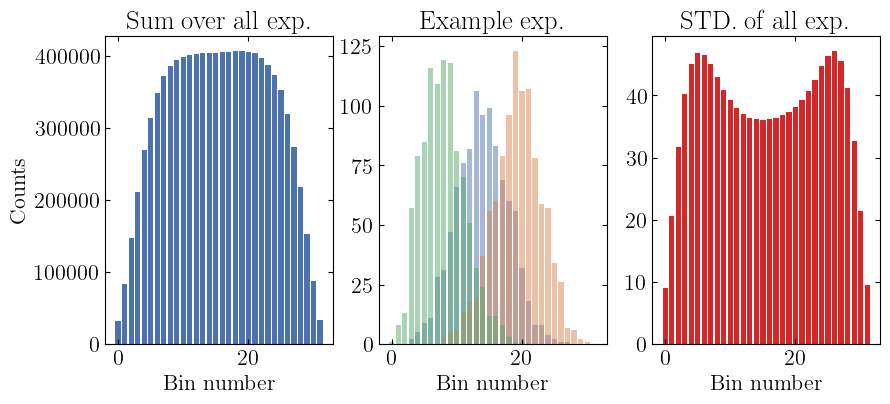

In [26]:

fig, ax = plt.subplots(1,3,figsize = (10, 4))

ax[0].bar(np.arange(32), board_data.sum(axis=0))
ax[0].set_xlabel('Bin number')
ax[0].set_ylabel('Counts')


ax[1].bar(np.arange(32), board_data[0],alpha=0.5)
ax[1].bar(np.arange(32), board_data[1],alpha=0.5)
ax[1].bar(np.arange(32), board_data[3],alpha=0.5)
ax[1].set_xlabel('Bin number')
ax[1].set_title('Example exp.')
ax[0].set_title('Sum over all exp.')
ax[2].set_title('STD. of all exp.')
ax[2].bar(np.arange(32), np.std(board_data,axis=0),color='tab:red')
ax[2].set_xlabel('Bin number')

plt.show()

In [27]:

fraction_train = 0.70; fraction_test = 0.10; fraction_valid = 1. - fraction_train - fraction_test

data_train = board_data[:int(fraction_train*len(board_data))]
data_test = board_data[int(fraction_train*len(board_data)):int((fraction_train+fraction_test)*len(board_data))+1]
data_valid = board_data[1+int((fraction_train+fraction_test)*len(board_data)):]


print(f"Training data size: {len(data_train)}")
print(f"Testing data size: {len(data_test)}")
print(f"Validation data size: {len(data_valid)}")

Training data size: 7000
Testing data size: 1000
Validation data size: 2000


In [28]:
def p_peg(alpha,M,s,left=True):
    if left:
        return 0.5 - (alpha * M + s)
    else:
        return 0.5 + (alpha * M + s)